In [1]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 2.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Using our merged dataset (train & val), alongside our given test data

This Task is task 1 (MEL VS NEVUS AND SEB). PLEASE USE APPROPRIATE PATH TO TASK1

In [3]:
#please set title for saving model correctly!!!
title = "mel_vs_nev&seb_aug"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from vit_keras import vit
import tensorflow_addons as tfa
import math

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
os.listdir('/content')

['.config', 'drive', 'sample_data']

In [7]:
#ViT model initialization
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

347502902/347502902 [==============================] - 20s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [8]:
# Add additional layers after the Vision Transformer

model = tensorflow.keras.Sequential([
    vit_model,
    Flatten(),
    Dense(128, activation=gelu),
    Dropout(0.1),
    LayerNormalization(epsilon=.000002),
    Dense(32, activation=gelu),
    Dropout(0.1),
    LayerNormalization(epsilon=.000002),
    Dense(2, activation='softmax')
], name='vision_transformer')



model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 layer_normalization (LayerN  (None, 128)              256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                

In [9]:
import tensorflow as tf
from tensorflow.keras import backend as K

#Custom function for loss function
def focal_loss(gamma=2, alpha=0.7):
    def focal_loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        focal_loss = -alpha * y_true * K.pow(1.0 - y_pred, gamma) * K.log(y_pred)
        return K.mean(focal_loss, axis=-1)
    return focal_loss_fn

#Compiling model using focal loss and adam optimizer
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

In [10]:
early_stopping = EarlyStopping(monitor='val_loss',patience=2)        #Configuring Early stopping criteria        

def step_decay(epoch):
    initial_lrate = 0.00002                                           #Configuring Learning rate
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [11]:
#Function for ploting graph for training and validation accuracy
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    roc = roc_auc_score(test_labels, predictions[:, 1]) # Calculating ROC score

    # Calculate confusion matrix 
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels)

    precision = precision_score(test_labels, predicted_labels, average='weighted')

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
# Set the directories for the data for task1 (MEL VS NEVUS AND SEB)
train_dir = "/content/drive/MyDrive/msc_project/train_merged_augumented/task1"
test_dir = "/content/drive/MyDrive/msc_project/test/task1"

In [14]:
# Combine the paths and corresponding labels for the stratified k-fold
train_paths = []
train_labels = []
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        for image_filename in os.listdir(class_path):
            train_paths.append(os.path.join(class_path, image_filename))
            train_labels.append(class_label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

In [15]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 10
num_fold = 5

# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=None)

In [16]:
model_path = f'/content/drive/MyDrive/msc_project/model/{title}'
os.makedirs(model_path, exist_ok=True)

Traning for Fold: 1
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.7288
Epoch 1: val_accuracy improved from -inf to 0.80769, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_aug/model_fold_1.hdf5
104/104 [==============================] - 1073s 10s/step - loss: 0.0895 - accuracy: 0.7288 - val_loss: 0.0596 - val_accuracy: 0.8077 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.0569 - accuracy: 0.7654
Epoch 2: val_accuracy improved from 0.80769 to 0.85769, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_aug/model_fold_1.hdf5
104/104 [==============================] - 945s 9s/step - loss: 0.0569 - accuracy: 0.7654

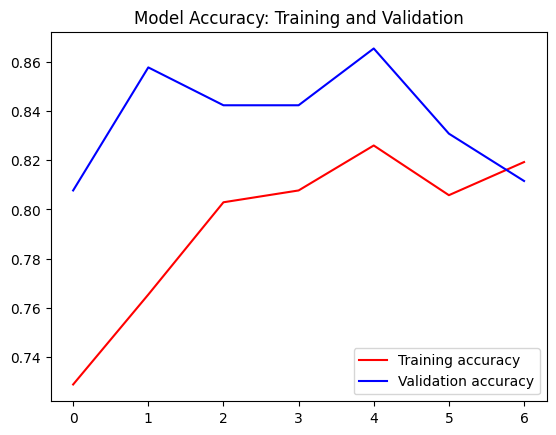

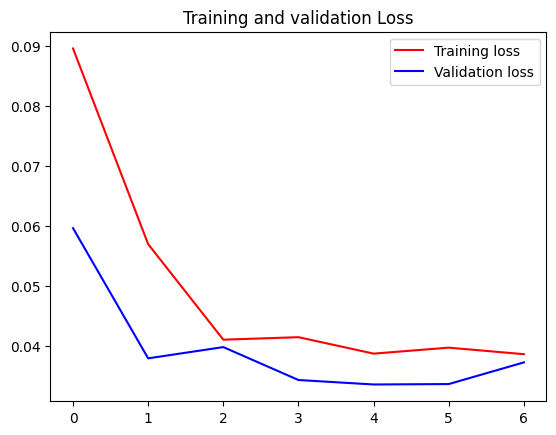

<Figure size 640x480 with 0 Axes>

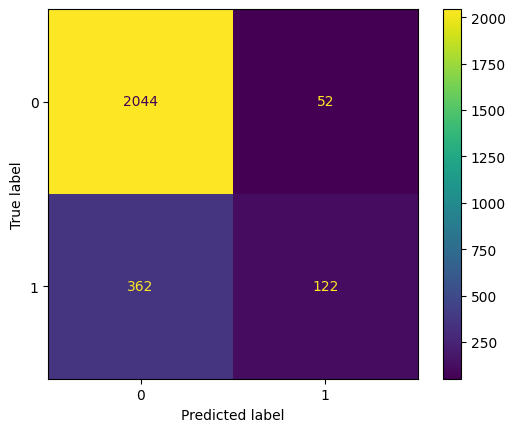


               precision    recall  f1-score   support

           0       0.85      0.98      0.91      2096
           1       0.70      0.25      0.37       484

    accuracy                           0.84      2580
   macro avg       0.78      0.61      0.64      2580
weighted avg       0.82      0.84      0.81      2580

Sensitivity: 0.252 Specificity: 0.975 Precision: 0.822 ROC_AUC_SCORE: 0.813



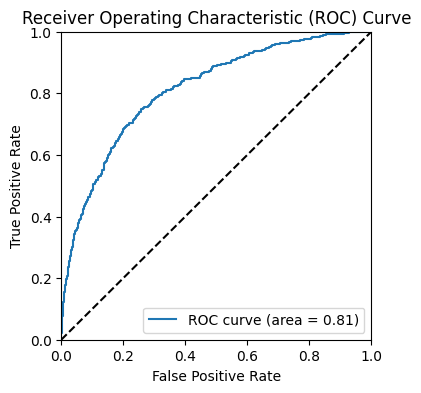

Validation complete...
Traning for Fold: 2
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.8000
Epoch 1: val_accuracy improved from -inf to 0.84615, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_aug/model_fold_2.hdf5
104/104 [==============================] - 470s 4s/step - loss: 0.0433 - accuracy: 0.8000 - val_loss: 0.0330 - val_accuracy: 0.8462 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.8077
Epoch 2: val_accuracy did not improve from 0.84615
104/104 [==============================] - 329s 3s/step - loss: 0.0398 - accuracy: 0.8077 - val_loss: 0.0351 - val_accuracy: 0.8077 - lr: 2.0000e-05

Epoch 3: Learning

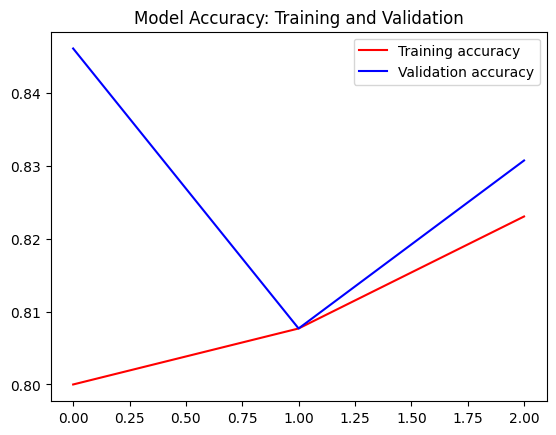

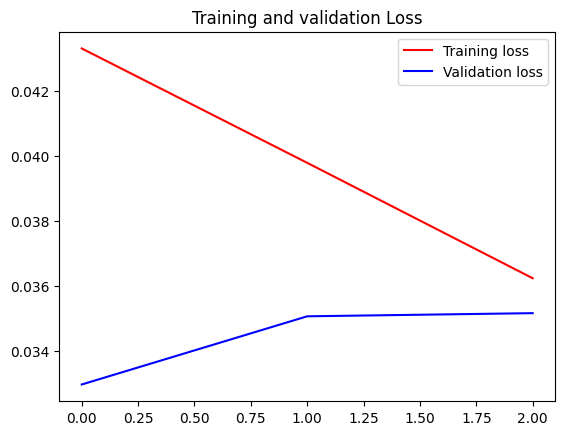

<Figure size 640x480 with 0 Axes>

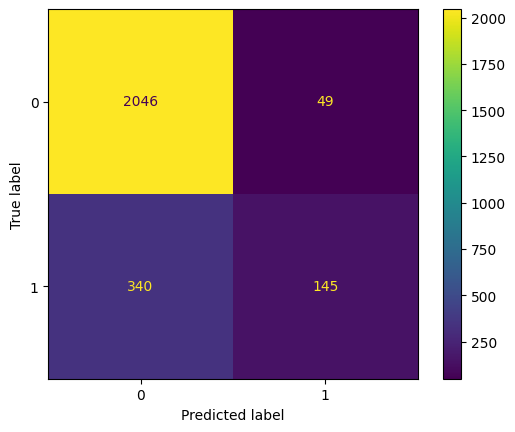


               precision    recall  f1-score   support

           0       0.86      0.98      0.91      2095
           1       0.75      0.30      0.43       485

    accuracy                           0.85      2580
   macro avg       0.80      0.64      0.67      2580
weighted avg       0.84      0.85      0.82      2580

Sensitivity: 0.299 Specificity: 0.977 Precision: 0.837 ROC_AUC_SCORE: 0.854



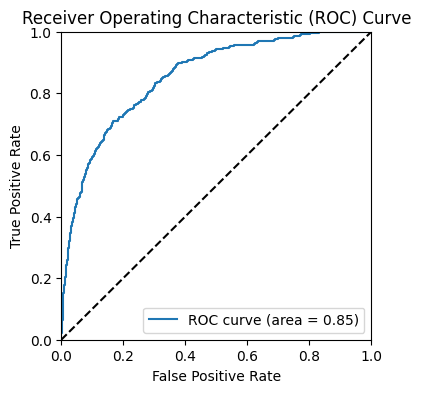

Validation complete...
Traning for Fold: 3
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.8010
Epoch 1: val_accuracy improved from -inf to 0.85000, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_aug/model_fold_3.hdf5
104/104 [==============================] - 250s 2s/step - loss: 0.0422 - accuracy: 0.8010 - val_loss: 0.0323 - val_accuracy: 0.8500 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.8510
Epoch 2: val_accuracy did not improve from 0.85000
104/104 [==============================] - 206s 2s/step - loss: 0.0337 - accuracy: 0.8510 - val_loss: 0.0293 - val_accuracy: 0.8423 - lr: 2.0000e-05

Epoch 3: Learning

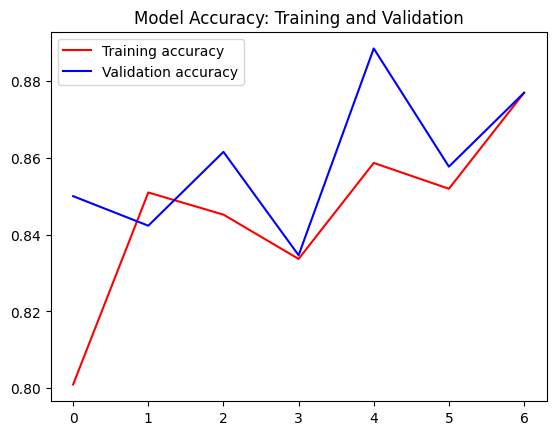

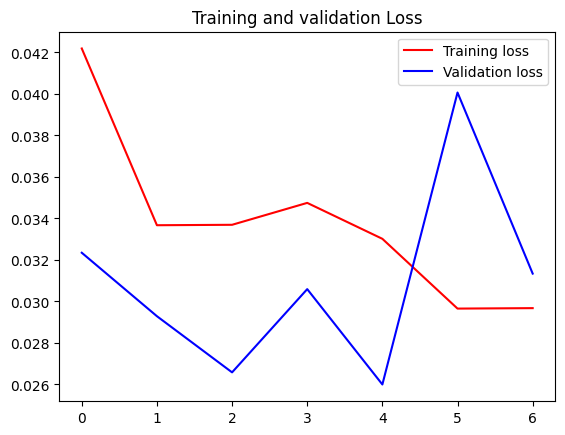

<Figure size 640x480 with 0 Axes>

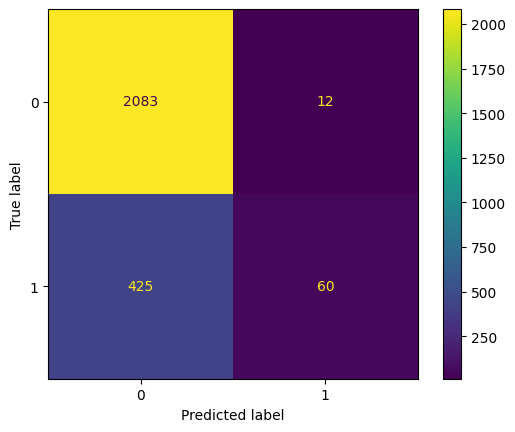


               precision    recall  f1-score   support

           0       0.83      0.99      0.91      2095
           1       0.83      0.12      0.22       485

    accuracy                           0.83      2580
   macro avg       0.83      0.56      0.56      2580
weighted avg       0.83      0.83      0.78      2580

Sensitivity: 0.124 Specificity: 0.994 Precision: 0.831 ROC_AUC_SCORE: 0.877



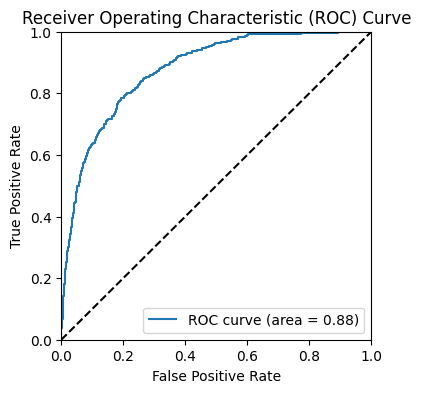

Validation complete...
Traning for Fold: 4
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.8558
Epoch 1: val_accuracy improved from -inf to 0.90769, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_aug/model_fold_4.hdf5
104/104 [==============================] - 163s 1s/step - loss: 0.0306 - accuracy: 0.8558 - val_loss: 0.0217 - val_accuracy: 0.9077 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 0.8481
Epoch 2: val_accuracy did not improve from 0.90769
104/104 [==============================] - 107s 1s/step - loss: 0.0327 - accuracy: 0.8481 - val_loss: 0.0309 - val_accuracy: 0.8462 - lr: 2.0000e-05

Epoch 3: Learning

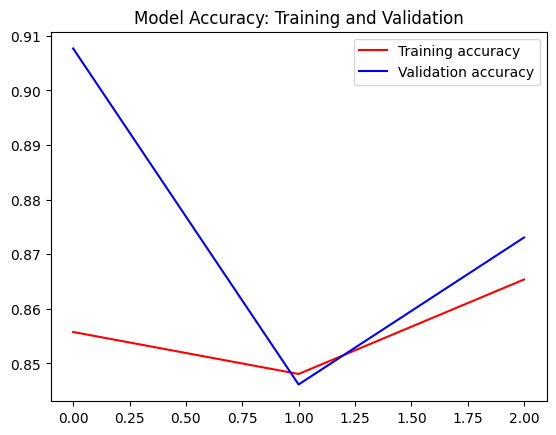

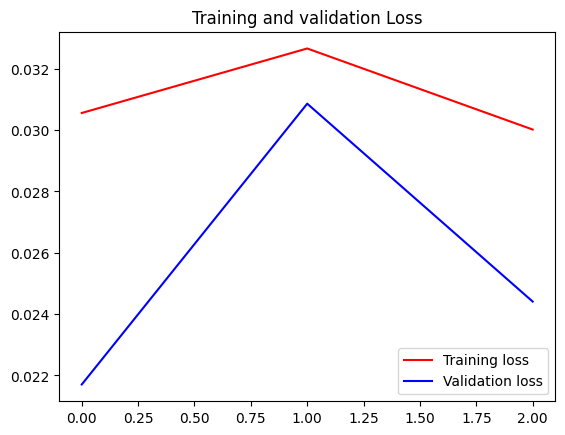

<Figure size 640x480 with 0 Axes>

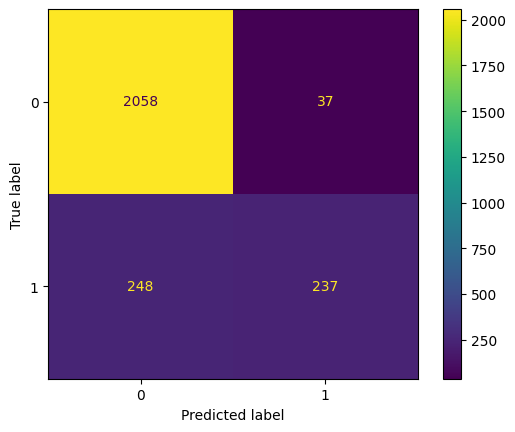


               precision    recall  f1-score   support

           0       0.89      0.98      0.94      2095
           1       0.86      0.49      0.62       485

    accuracy                           0.89      2580
   macro avg       0.88      0.74      0.78      2580
weighted avg       0.89      0.89      0.88      2580

Sensitivity: 0.489 Specificity: 0.982 Precision: 0.887 ROC_AUC_SCORE: 0.933



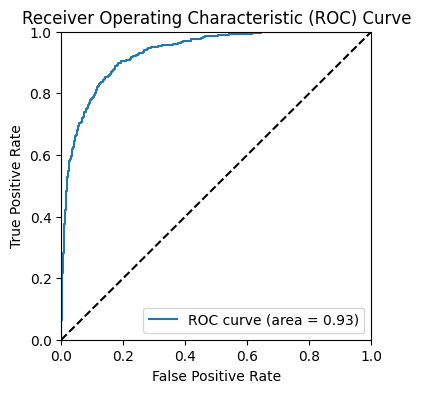

Validation complete...
Traning for Fold: 5
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.8721
Epoch 1: val_accuracy improved from -inf to 0.87308, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_aug/model_fold_5.hdf5
104/104 [==============================] - 122s 708ms/step - loss: 0.0311 - accuracy: 0.8721 - val_loss: 0.0255 - val_accuracy: 0.8731 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.8635
Epoch 2: val_accuracy improved from 0.87308 to 0.93846, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_aug/model_fold_5.hdf5
104/104 [==============================] - 91s 883ms/step - loss:

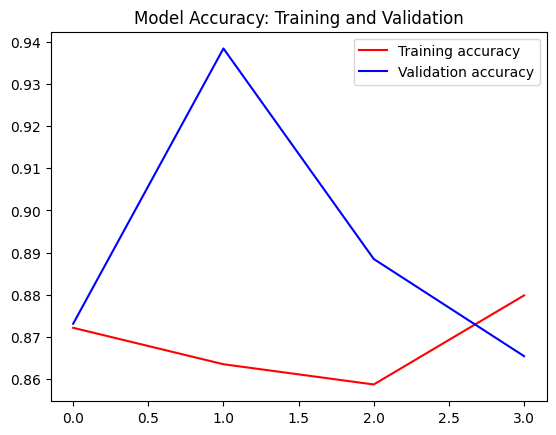

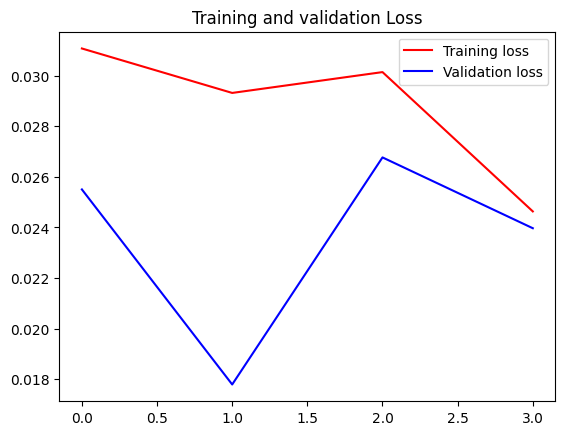

<Figure size 640x480 with 0 Axes>

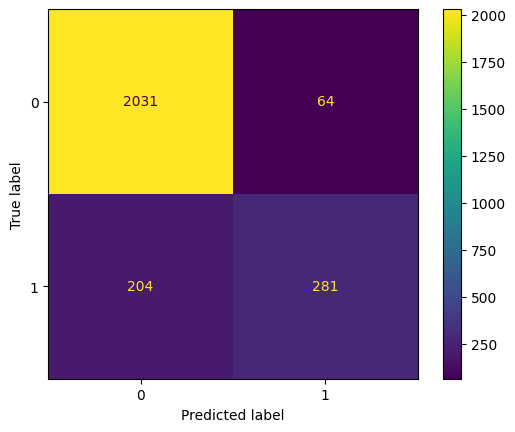


               precision    recall  f1-score   support

           0       0.91      0.97      0.94      2095
           1       0.81      0.58      0.68       485

    accuracy                           0.90      2580
   macro avg       0.86      0.77      0.81      2580
weighted avg       0.89      0.90      0.89      2580

Sensitivity: 0.579 Specificity: 0.969 Precision: 0.891 ROC_AUC_SCORE: 0.928



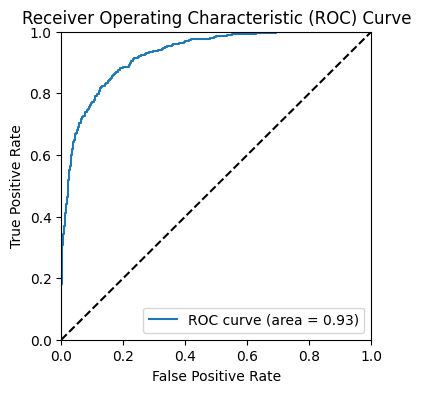

Validation complete...


In [17]:
# Perform k-fold cross-validation
fold = 1
for i, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
#     print(f"Fold {i}:")
    print(f"Traning for Fold: {fold}")
    # Split the data into train and validation sets for this fold
    train_paths_fold, val_paths_fold = train_paths[train_index], train_paths[val_index]
    train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold = datagen.flow_from_dataframe(
      pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
      directory=train_dir,
      x_col='filename',
      y_col='class',
      target_size=image_size,
      batch_size=batch
  )

    train_steps = np.ceil(len(train_generator_fold) / batch)               #number of train steps
    val_steps = np.ceil(len(val_generator_fold) / batch)                   #number of validation steps

    #set path to save model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_path + f'/model_fold_{fold}.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

    callbacks = [early_stopping, checkpointer, lr_scheduler]


    # Compile the model
    model.compile(
        optimizer='adam',
        loss=focal_loss(),
        metrics=['accuracy']
    )

    # Train the model on the training data and evaluate on the validation data
    history = model.fit(
        train_generator_fold,
        steps_per_epoch=train_steps,
        validation_data=val_generator_fold,
        validation_steps=val_steps,
        epochs=10,
        callbacks=callbacks)

    graph_it(history)


    val_generator_fold_test = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    print(f"\nValidating for fold {fold}... \n")
    print("Loading model...")

    model.load_weights(filepath = model_path + f'/model_fold_{fold}.hdf5')
    test_it(model, val_generator_fold_test)

    print("Validation complete...")

    fold += 1


**Model Evaluation using test data**

In [18]:
test_dir

'/content/drive/MyDrive/msc_project/test/task1'

In [19]:
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )
test_generator.shuffle = False

Found 600 images belonging to 2 classes.


Test using model 1
600/600 [==============================] - 27s 45ms/step


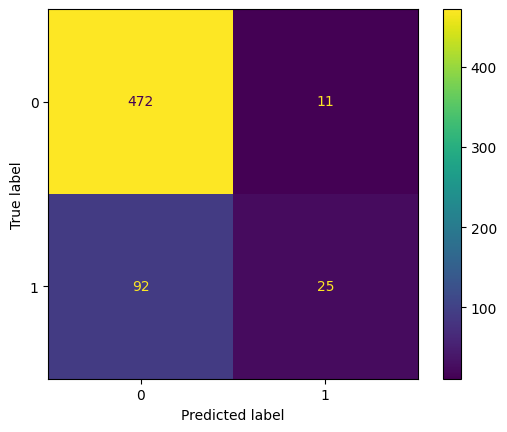


               precision    recall  f1-score   support

           0       0.84      0.98      0.90       483
           1       0.69      0.21      0.33       117

    accuracy                           0.83       600
   macro avg       0.77      0.60      0.61       600
weighted avg       0.81      0.83      0.79       600

Sensitivity: 0.214 Specificity: 0.977 Precision: 0.809 ROC_AUC_SCORE: 0.781



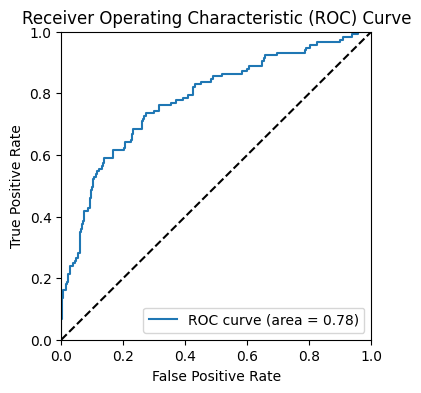

Testing Complete
Test using model 2
600/600 [==============================] - 26s 43ms/step


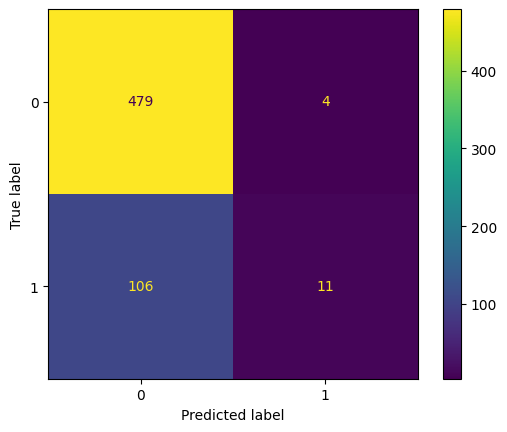


               precision    recall  f1-score   support

           0       0.82      0.99      0.90       483
           1       0.73      0.09      0.17       117

    accuracy                           0.82       600
   macro avg       0.78      0.54      0.53       600
weighted avg       0.80      0.82      0.75       600

Sensitivity: 0.094 Specificity: 0.992 Precision: 0.802 ROC_AUC_SCORE: 0.8



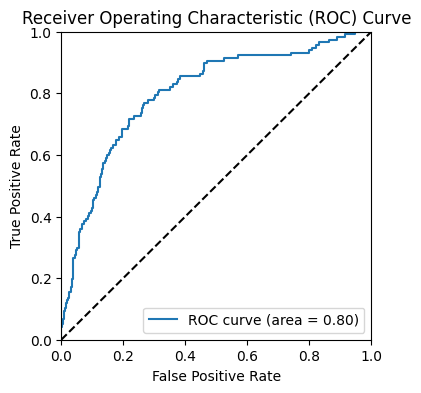

Testing Complete
Test using model 3
600/600 [==============================] - 25s 42ms/step


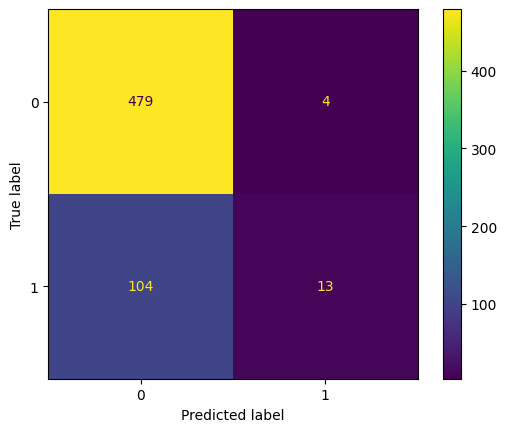


               precision    recall  f1-score   support

           0       0.82      0.99      0.90       483
           1       0.76      0.11      0.19       117

    accuracy                           0.82       600
   macro avg       0.79      0.55      0.55       600
weighted avg       0.81      0.82      0.76       600

Sensitivity: 0.111 Specificity: 0.992 Precision: 0.811 ROC_AUC_SCORE: 0.809



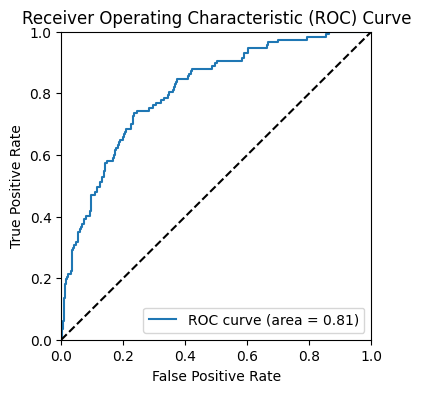

Testing Complete
Test using model 4
600/600 [==============================] - 27s 45ms/step


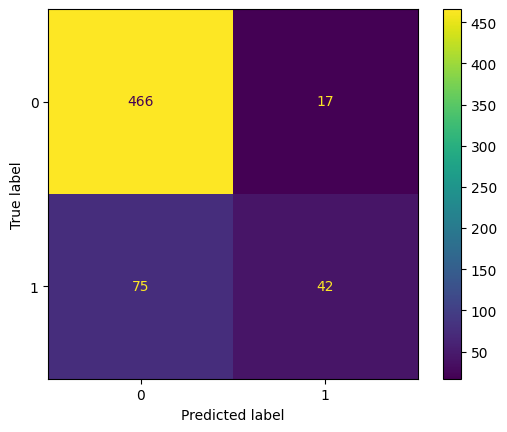


               precision    recall  f1-score   support

           0       0.86      0.96      0.91       483
           1       0.71      0.36      0.48       117

    accuracy                           0.85       600
   macro avg       0.79      0.66      0.69       600
weighted avg       0.83      0.85      0.83       600

Sensitivity: 0.359 Specificity: 0.965 Precision: 0.832 ROC_AUC_SCORE: 0.836



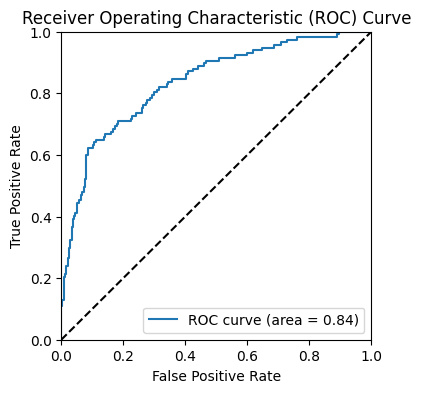

Testing Complete
Test using model 5
600/600 [==============================] - 27s 46ms/step


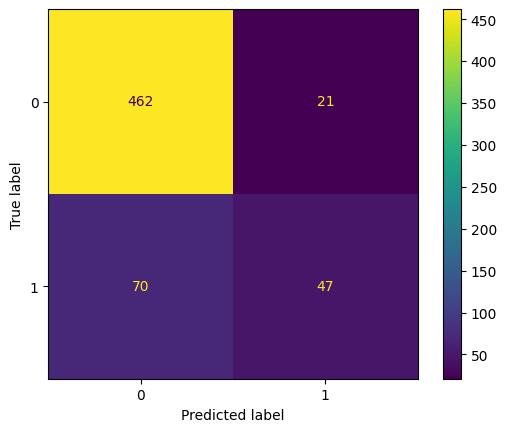


               precision    recall  f1-score   support

           0       0.87      0.96      0.91       483
           1       0.69      0.40      0.51       117

    accuracy                           0.85       600
   macro avg       0.78      0.68      0.71       600
weighted avg       0.83      0.85      0.83       600

Sensitivity: 0.402 Specificity: 0.957 Precision: 0.834 ROC_AUC_SCORE: 0.847



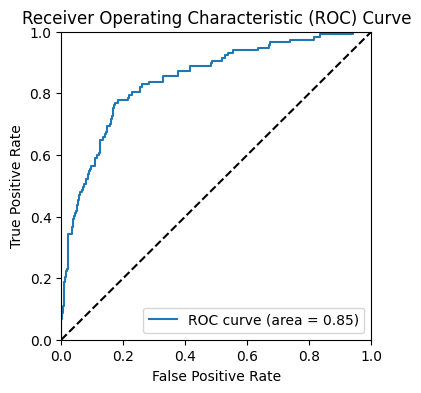

Testing Complete


In [21]:
#set path to best weights from your training please manually! {title}_fold_{fold}
for i in range(1, num_fold+1):
  print(f"Test using model {i}")
  model.load_weights(filepath = model_path + f'/model_fold_{i}.hdf5')
  test_it(model, test_generator)
  print("Testing Complete")